<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


<AxesSubplot:>

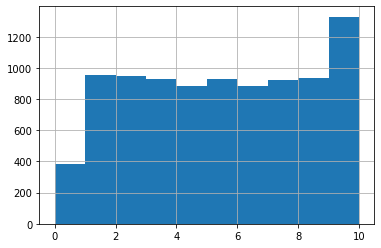

In [2]:
churn = pd.read_csv('/datasets/Churn.csv')
display(churn.head(3))
print(churn.info())
churn['Tenure'].hist()

In [3]:
churn['Tenure'] = churn['Tenure'].fillna(churn['Tenure'].median())
encoder = OrdinalEncoder()
churn_ordinal = pd.DataFrame(encoder.fit_transform(churn),columns=churn.columns)
display(churn_ordinal.head(3))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0.0,2736.0,1115.0,228.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,5068.0,1.0
1,1.0,3258.0,1177.0,217.0,2.0,0.0,23.0,1.0,743.0,0.0,0.0,1.0,5639.0,0.0
2,2.0,2104.0,2040.0,111.0,0.0,0.0,24.0,8.0,5793.0,2.0,1.0,0.0,5707.0,1.0


В целом данные относительно чистые, только колонка Tenure не досчиталась около 10% данных, которые были заполнены медианным значением. Почему медианным? Потому что, как видно на гистограмме, есть небольшая часть значений "1" (около 390) и наибольшая часть значений "10" (около 1350). Такие разбросы влияют на среднее, но не на медиану. Также переменные класса object были закодированы с помощью Ordinal Encoder.

## Исследование задачи

In [4]:
# Проверка на дисбаланс классов
churn_ordinal['Exited'].value_counts()

0.0    7963
1.0    2037
Name: Exited, dtype: int64

In [6]:
# Разделение на train, validation, и test выборки
target = churn_ordinal['Exited']
features = churn_ordinal.drop('Exited', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345)

# Построение модели без учета дисбаланса классов
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train,target_train)
predicted_valid = model.predict(features_valid)
accuracy_valid = accuracy_score(target_valid,predicted_valid)
print(accuracy_valid)

# Проверка модели на адекватность
zeros = [0] * len(target)
target_pred_constant = pd.Series(zeros)
print(accuracy_score(target, target_pred_constant))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# F-1 и AUC-ROC меры для модели без учета дисбаланса классов
print(f1_score(target_valid, predicted_valid))
print(roc_auc_score(target_valid, probabilities_one_valid))

0.7856
0.7963
0.49370277078085645
0.6849850378454497


Заметен дисбаланс классов целевого признака, так как баланс классов не равен 1:1. Была постороена модель без учета дисбаланса классов и константная модель для проверки ее адекватности. Как и продполагалось модель не прошла тест на адекватность, так как разница с константной моделью составила менее 2%. Также были проверены меры F-1 и AUC-ROC для сравнения ее улучшения построения модели с учетом дисбаланса классов. 

## Борьба с дисбалансом

In [7]:
# Взвешивание классов
model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model.fit(features_train,target_train)
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print(f1_score(target_valid, predicted_valid))
print(roc_auc_score(target_valid, probabilities_one_valid))

0.46256684491978606
0.6624141876430206


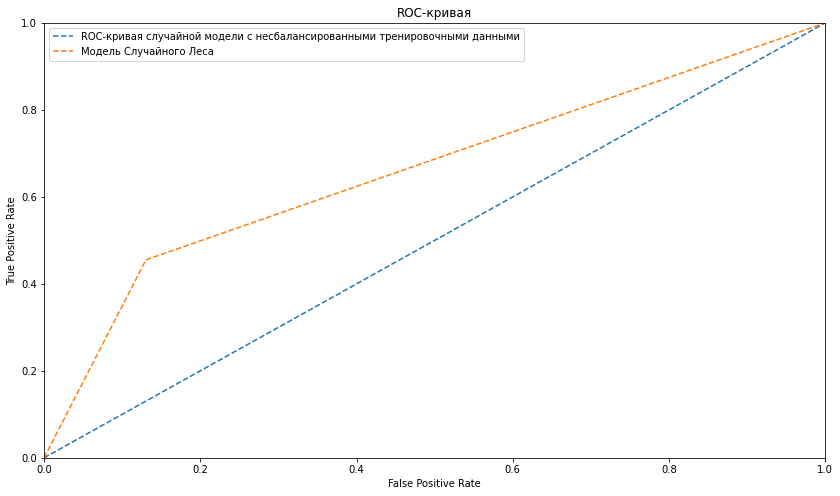

In [8]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure(figsize=(14,8))
plt.plot([0, 1], [0, 1], linestyle='--', label='ROC-кривая случайной модели с несбалансированными тренировочными данными') # ROC-кривая случайной модели (выглядит как прямая)
plt.plot(fpr, tpr, linestyle='--', label='Модель Случайного Леса')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend()
plt.show()

In [9]:
# Увеличение выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
print(target_upsampled.value_counts())

0.0    4503
1.0    4488
Name: Exited, dtype: int64


In [10]:
# Уменьшение выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
print(target_downsampled.value_counts())

0.0    1126
1.0    1122
Name: Exited, dtype: int64


Первый метод использованный для борьбы с дисбалансом классов - взвешивание классов, это параметр моделей классификации, который придает больший вес тому классу, который является меньшим по численности. Вызов этого метода, однако, не помог ее улучшуть, а скорее наоборот незначительно ухудшил ее качество. Следующие 2 способа борьбы с дисбалансом классов это upsampling и downsampling. Это соотвественно увеличение и уменьшение выборки с заполнением объектов редкого класса. После использования этих способов соотношение классов 1:1 было достигнуто, и данные будут протестированы в следующей секции.  

## Тестирование модели

In [11]:
model = RandomForestClassifier(random_state=12345,class_weight='balanced')
model.fit(features_upsampled,target_upsampled)
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("F1:", f1_score(target_valid, predicted_valid))
print(roc_auc_score(target_valid, probabilities_one_valid))

F1: 0.5771604938271605
0.8569309980637213


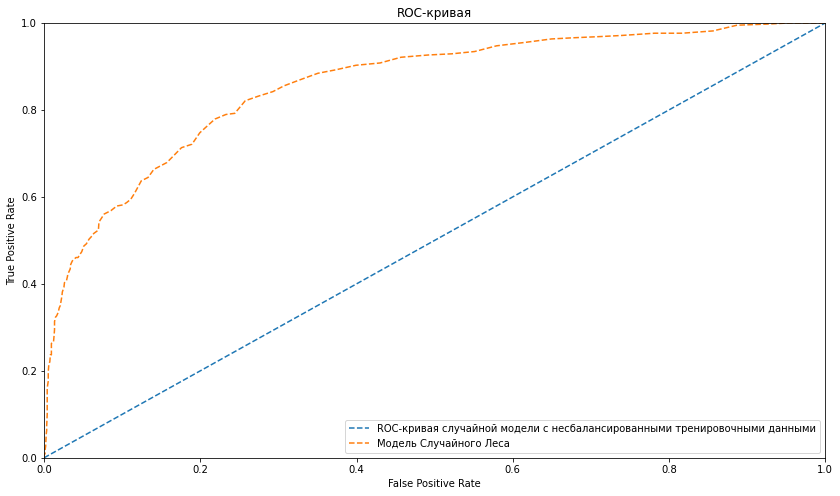

In [12]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure(figsize=(14,8))
plt.plot([0, 1], [0, 1], linestyle='--', label='ROC-кривая случайной модели с несбалансированными тренировочными данными') # ROC-кривая случайной модели (выглядит как прямая)
plt.plot(fpr, tpr, linestyle='--', label='Модель Случайного Леса')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend()
plt.show()

После применения увеличения выборки показатели F-1 и AUC-ROC заметно улучшились, что и заметно по кривой ROC. Однако, цель достичь показателя 0.59 для F-1 меры пока не покорилась.

In [13]:
model = RandomForestClassifier(random_state=12345,class_weight='balanced')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("F1:", f1_score(target_valid, predicted_valid))
print(roc_auc_score(target_valid, probabilities_one_valid))

F1: 0.5926660059464817
0.8615067769758845


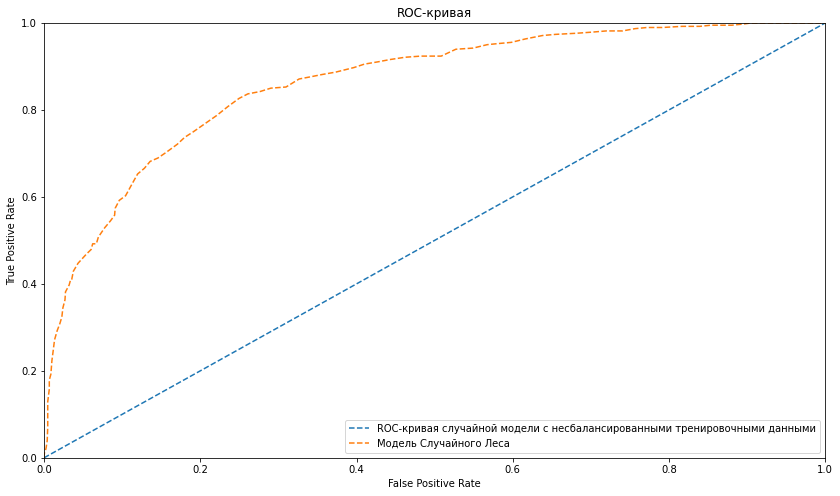

In [14]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure(figsize=(14,8))
plt.plot([0, 1], [0, 1], linestyle='--', label='ROC-кривая случайной модели с несбалансированными тренировочными данными') # ROC-кривая случайной модели (выглядит как прямая)
plt.plot(fpr, tpr, linestyle='--', label='Модель Случайного Леса')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend()
plt.show()

Бинго! Уменьшение выборки улучшило модель еще больше, и показатель F-1 меры стал 0.59, что позволяет принять модель. Показатель AUC-ROC почти не изменился при уменьшении выборки по сравнению с увеличнием выборки. Осталось проверить эффективность модели и данных на тестовой выборке.

In [ ]:
model = RandomForestClassifier(random_state=12345,class_weight='balanced')
model.fit(features_downsampled, target_downsampled)
predicted_test = model.predict(features_test)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print("F1:", f1_score(target_test, predicted_test))
print(roc_auc_score(target_test, probabilities_one_test))

<b> Общий вывод:</b> Был исследован отток клиентов в банке, где нужно было спрогнозировать уйдет ли тот или иной клиент из банка или нет. в целевом признаке был дисбаланс классов, который сильно влиял на адекватность модели, так как константная модель заполненная нулями отработала не хуже. В итоге, были применены способы увеличения и уменьшения выборки. Последняя помогла достичь цели - получить меру F-1 с показателем 0.61 (на тестовой выборке). Метрика AUC-ROC также заметно улучшилась с 0.67 до 0.85.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*